In [2]:
const USE_GPU = true  # Use GPU? If this is set false, then no GPU needs to be available
using Revise
using ParallelStencil
using ParallelStencil.FiniteDifferences3D
using ProgressMeter
# using CUDA
using NamedArrays
using OrderedCollections

using Plots, Printf, Statistics



@init_parallel_stencil(CUDA, Float64, 3)
#     @init_parallel_stencil(Threads, Float64, 3)
using GeoPhyInv
plotly()
gr()


┌ Error: Some Julia code in the VS Code extension crashed
└ @ VSCodeServer /home/pawan/.vscode-server-insiders/extensions/julialang.language-julia-1.3.33/scripts/error_handler.jl:15
ERROR: MethodError: no method matching revise()
The applicable method may be too new: running in world age 29612, while current world is 29715.
Closest candidates are:
  revise(; throw) at /home/pawan/.julia/packages/Revise/OgnOk/src/packagedef.jl:733 (method too new to be called from this world context.)
  revise(::REPL.REPLBackend) at /home/pawan/.julia/packages/Revise/OgnOk/src/packagedef.jl:832 (method too new to be called from this world context.)
  revise(::Module) at /home/pawan/.julia/packages/Revise/OgnOk/src/packagedef.jl:840 (method too new to be called from this world context.)
Stacktrace:
 [1] revise()
   @ VSCodeServer ~/.vscode-server-insiders/extensions/julialang.language-julia-1.3.33/scripts/packages/VSCodeServer/src/misc.jl:157
 [2] (::VSCodeServer.var"#98#99"{VSCodeServer.NotebookRunCellA

In [3]:
mgrid=fill(range(-500, stop=500, length=255), 3);
nx,ny,nz=length.(mgrid);
dx,dy,dz=step.(mgrid);
medium=Medium(mgrid,[:vp,:rho,:vs])
vpb = [3000., 3500.] # bounds for vp
vsb = [1900, 2000] # bounds for vs
rhob = [1., 2.] # density bounds
GeoPhyInv.update!(medium, [:vp,:vs,:rho], [vpb,vsb,rhob]);
fill!(medium);
# GeoPhyInv.update!(medium, [:vp,:vs,:rho], randn_perc=5); # add some random noise
# medium

medium.bounds[:vs]

2-element Vector{Float64}:
 1900.0
 2000.0

nt:	1935

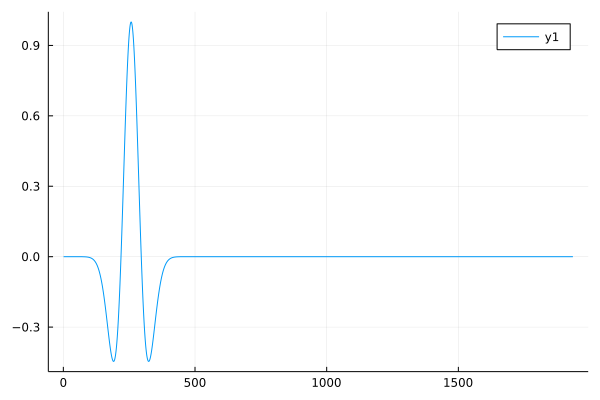

In [4]:
wav, tgrid=ricker(medium, 4, 1, 0.4)
dt=step(tgrid)

tmax=maximum(tgrid); nt=length(tgrid); 
print("nt:\t",length(tgrid))


freqmax=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:max)
freqpeak=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:peak)
freqmin=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:min)

plot(wav)

In [5]:
freqpeak

12.6343669250646

In [6]:

GeoPhyInv.check_fd_stability(medium.bounds, mgrid, tgrid, freqmin, freqmax, true, 10, 0.5)

┌ Info: spatial sampling (3.94e+00) can be as high as 5.01e+00
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/fdtd.jl:993
┌ Info: time sampling (4.50e-04) can be as high as 4.88e-04
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/fdtd.jl:1008


In [7]:
pml=GeoPhyInv.pml_variables(nx,dt,dx,40,vpb[2],vpb[1],freqpeak,[true, true]);
pmlx=NamedArray([CUDA.CuArray(pml[f]) for f in names(pml)[1]], names(pml)[1]);
pml=GeoPhyInv.pml_variables(ny,dt,dy,40,vpb[2],vpb[1],freqpeak,[true, true]);
pmly=NamedArray([CUDA.CuArray(pml[f]) for f in names(pml)[1]], names(pml)[1]);
pml=GeoPhyInv.pml_variables(nz,dt,dz,40,vpb[2],vpb[1],freqpeak,[false, true]);
pmlz=NamedArray([CUDA.CuArray(pml[f]) for f in names(pml)[1]], names(pml)[1]);

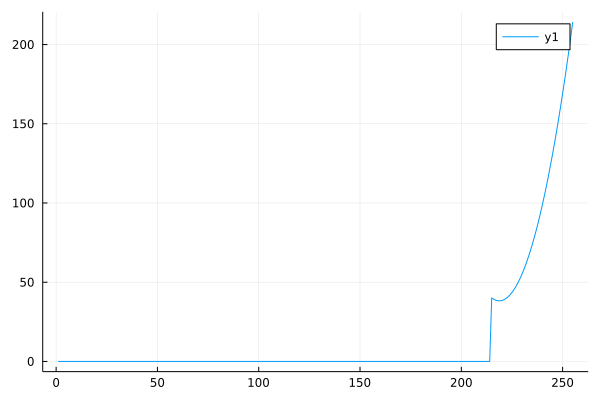

In [8]:
plot(pml[:a])
plot!(pml[:a_half])
# plot(pml[:b])
# plot!(pml[:b_half])
# plot(pml[:alpha_x])
# plot!(pml[:alpha_x_half])
# plot!(pml[:b_half])
plot(pml[:d_x]+pml[:alpha_x])
# plot!(pml[:d_x_half])


In [9]:
macroexpand(Main, :(@d_xi(mu)))

:(mu[var"##ix, ParallelStencil#264" + 1, var"##iy, ParallelStencil#265" + 1, var"##iz, ParallelStencil#266" + 1] - mu[var"##ix, ParallelStencil#264", var"##iy, ParallelStencil#265" + 1, var"##iz, ParallelStencil#266" + 1])

In [10]:
# these relative indices of the arrays point to same location
# [ix,iy,iz]     --> tauxx, tauyy, and tauzz grid
# [ix+1/2,iy+1/2,iz+1]      --> tauxy
# [ix+1/2,iy+1,iz+1/2]      -->  tauxz
# [ix-1/2,iy,iz]       --> vx
# [ix,iy-1/2,iz]       --> vy
# [ix,iy,iz-1/2]       --> vz

@parallel function compute_dtau!(tauxx::Data.Array, tauyy::Data.Array, tauzz::Data.Array, tauxy::Data.Array, tauxz::Data.Array, tauyz::Data.Array, 
    dtauxx_dx, dtauxy_dx, dtauxz_dx, dtauyy_dy, dtauxy_dy, dtauyz_dy, dtauzz_dz, dtauyz_dz, dtauxz_dz, dx::Data.Number, dy::Data.Number, dz::Data.Number)

    @all(dtauxx_dx) = @d_xi(tauxx) / dx # at [ix+1/2,iy+1,iz+1]
    @all(dtauxy_dx) = @d_xa(tauxy) / dx # at [ix+1,iy+1/2,iz+1]
    @all(dtauxz_dx) = @d_xa(tauxz) / dx # at [ix+1,iy+1,iz+1/2]


    @all(dtauyy_dy) = @d_yi(tauyy) / dy # at [ix+1,iy+1/2,iz+1]
    @all(dtauxy_dy) = @d_ya(tauxy) / dy # at [ix+1/2,iy+1,iz+1]
    @all(dtauyz_dy) = @d_ya(tauyz) / dy # at [ix+1,iy+1,iz+1/2]


    @all(dtauzz_dz) = @d_zi(tauzz) / dz # at [ix+1,iy+1,iz+1/2]
    @all(dtauxz_dz) = @d_za(tauxz) / dz # at [ix+1/2,iy+1,iz+1]
    @all(dtauyz_dz) = @d_za(tauyz) / dz # at [ix+1,iy+1/2,iz+1]

    return
end
@parallel function compute_V!(vx::Data.Array, vy::Data.Array, vz::Data.Array, 
    dtauxx_dx, dtauxy_dx, dtauxz_dx, dtauyy_dy, dtauxy_dy, dtauyz_dy, dtauzz_dz, dtauyz_dz, dtauxz_dz,
    dt::Data.Number, rho)
  
    @inn(vx) = @inn(vx) - dt / @av_xi(rho) * (@all(dtauxx_dx) + @all(dtauxy_dy) + @all(dtauxz_dz))
    @inn(vy) = @inn(vy) - dt / @av_yi(rho) * (@all(dtauxy_dx) + @all(dtauyy_dy) + @all(dtauyz_dz))
    @inn(vz) = @inn(vz) - dt / @av_zi(rho) * (@all(dtauxz_dx) + @all(dtauyz_dy) + @all(dtauzz_dz))

    return
end


@parallel function compute_dv!(vx, vy, vz,dvx_dx,dvy_dy,dvz_dz,dvx_dy,dvx_dz,dvy_dx,dvy_dz,dvz_dx,dvz_dy, dx,dy,dz)


    @all(dvx_dx) = @d_xa(vx) / dx # at [ix,iy,iz]
    @all(dvy_dy) = @d_ya(vy) / dy # at      "
    @all(dvz_dz) = @d_za(vz) / dz # at      "


    @all(dvx_dy) = @d_yi(vx) / dy # at [ix+1/2,iy+1/2,iz+1]
    @all(dvx_dz) = @d_zi(vx) / dz # at [ix+1/2,iy+1,iz+1/2]

    @all(dvy_dz) = @d_zi(vy) / dz # at [ix+1,iy+1/2,iz+1/2]
    @all(dvy_dx) = @d_xi(vy) / dx # at [ix+1/2,iy+1/2,iz+1]

    @all(dvz_dx) = @d_xi(vz) / dx # at [ix+1/2,iy+1,iz+1/2]
    @all(dvz_dy) = @d_yi(vz) / dy # at [ix+1,iy+1/2,iz+1/2]


    return
end


@parallel function compute_tauii!(tauxx::Data.Array, tauyy::Data.Array, tauzz::Data.Array,dvx_dx::Data.Array, dvy_dy::Data.Array, dvz_dz::Data.Array, dt::Data.Number, lambda2mu::Data.Array, lambda::Data.Array)

    @all(tauxx) = @all(tauxx) - dt * ((@all(lambda2mu)*(@all(dvx_dx)))  + (@all(lambda)*(@all(dvy_dy) + @all(dvz_dz))))
    @all(tauyy) = @all(tauyy) - dt * ((@all(lambda2mu)*@all(dvy_dy))  + (@all(lambda)*(@all(dvx_dx) + @all(dvz_dz))))
    @all(tauzz) = @all(tauzz) - dt * ((@all(lambda2mu)*@all(dvz_dz))  + (@all(lambda)*(@all(dvy_dy) + @all(dvx_dx))))
    return
end
@parallel function compute_tauij!(tauxy::Data.Array, tauxz::Data.Array, tauyz::Data.Array,dvx_dy,dvx_dz,dvy_dx,dvy_dz,dvz_dx,dvz_dy, dt::Data.Number, mu::Data.Array)
    @all(tauxz) = @all(tauxz) - dt * (@av_xzi(mu) * (@all(dvx_dz) + @all(dvz_dx)))
    @all(tauxy) = @all(tauxy) - dt * (@av_xyi(mu) * (@all(dvx_dy) + @all(dvy_dx)))
    @all(tauyz) = @all(tauyz) - dt * (@av_yzi(mu) * (@all(dvy_dz) + @all(dvz_dy)))

    return
end



compute_tauij! (generic function with 1 method)

In [11]:
for dim in [:x,:y,:z]
	fname=Symbol("memory",string(dim),"!")
    i=Symbol("i",string(dim))
    @eval @parallel_indices (ix,iy,iz) function $fname(memory::Data.Array, d::Data.Array, a, b, kI )
        memory[ix,iy,iz] = b[$i] * memory[ix,iy,iz] + a[$i] * d[ix,iy,iz]
        d[ix,iy,iz] = d[ix,iy,iz] * kI[$i] + memory[ix,iy,iz]
        return
    end
	fname=Symbol("memory1",string(dim),"!")
    @eval @parallel_indices (ix,iy,iz) function $fname(memory::Data.Array, d::Data.Array, a, b, kI )
        memory[ix,iy,iz] = b[$i+1] * memory[ix,iy,iz] + a[$i+1] * d[ix,iy,iz]
        d[ix,iy,iz] = d[ix,iy,iz] * kI[$i+1] + memory[ix,iy,iz]
        return
    end
	fname=Symbol("dirichlet",string(dim),"!")
    is=[:ix, :iy,:iz]

    is1=replace(is, i=>1); is2=replace(is, i=>2)
    is3=replace(is, i=>3); is4=replace(is, i=>4)
    isnp1=replace(is, i=>:(n+1))
    isn=replace(is, i=>:n)
    isnm1=replace(is, i=>:(n-1))

    i1,i2=filter(x->x!=i,is)
    v=Symbol("v",string(dim))
    vs=(:vx, :vy,:vz)
    v1,v2=filter(x->x!=v,vs)
    
    @eval @parallel_indices ($i1,$i2) function $fname(vx,vy,vz,n)
        $v[$(is3...)]=-$v[$(is4...)]
        $v[$(isnp1...)]=-$v[$(isn...)]
        $v1[$(is2...)]=0
        $v1[$(isnm1...)]=0
        $v2[$(is2...)]=0
        $v2[$(isnm1...)]=0
        return
    end
end
# @parallel_indices (ix,iy,iz) function memoryy!(memory::Data.Array, d::Data.Array, a, b, kI )
    # memory[ix,iy,iz] = b[iy] * memory[ix,iy,iz] + a[iy] * d[ix,iy,iz]
    # d[ix,iy,iz] = d[ix,iy,iz] * kI[iy] + memory[ix,iy,iz]
    # return
# end
# @parallel_indices (ix,iy,iz) function memoryz!(memory::Data.Array, d::Data.Array, a, b, kI )
    # memory[ix,iy,iz] = b[iz] * memory[ix,iy,iz] + a[iz] * d[ix,iy,iz]
    # d[ix,iy,iz] = d[ix,iy,iz] * kI[iz] + memory[ix,iy,iz]
    # return
# end

# @parallel (1:nx,1:ny,1:nz) memoryx!(memory_dvx_dx, dvx_dx, pmlx[:a], pmlx[:b], pmlx[:kI])

# pmlx[:kI]
# memoryx!

In [12]:
# filter(x->x!=:ix,[:ix, :iy,:iz])

is=[:ix,:iy,:iz]
replace(is, :ix=>:(n-1))

3-element Vector{Any}:
 :(n - 1)
 :iy
 :iz

In [13]:
nz, ny, nx = length.(mgrid)
# Physics
lx, ly, lz = 1000.0, 1000.0, 1000.0  # domain extends
lambda = @zeros(nx, ny, nz)               # lame parameter
lambda2mu = @zeros(nx, ny, nz)               # lame parameter
mu = @zeros(nx, ny, nz)
rho = @zeros(nx, ny, nz)

# mu = medium[:mu]          # mu parameter
copyto!(mu, medium[:mu])
copyto!(rho, medium[:rho])
copyto!(lambda, medium[:lambda])
copyto!(lambda2mu, medium[:M]) # P-wave modulus M

nout = div(length(tgrid), 100)            # plotting frequency,10


# fields=[:tauxx,:tauyy,:tauzz,:tauxy,:tauxz,:tauyz,:vx,:vz,:vy]
# w2=NamedArray([NamedArray([@zeros(nx,ny,nz) for i in fields], (fields,)) for i in 1:5], ([:t, :tp, :tpp, :dx, :dy, :dz],))




# Array allocations
tauxx = @zeros(nx, ny, nz)
tauyy = @zeros(nx, ny, nz)
tauzz = @zeros(nx, ny, nz)
tauxy = @zeros(nx - 1, ny - 1, nz - 2)
tauxz = @zeros(nx - 1, ny - 2, nz - 1)
tauyz = @zeros(nx - 2, ny - 1, nz - 1)

vx = @zeros(nx + 1, ny, nz)
vy = @zeros(nx, ny + 1, nz)
vz = @zeros(nx, ny, nz + 1)


dvx_dx = @zeros(nx, ny, nz)
dvy_dy = @zeros(nx, ny, nz)
dvz_dz = @zeros(nx, ny, nz)


dvx_dy = @zeros(nx - 1, ny - 1, nz - 2)
dvx_dz = @zeros(nx - 1, ny - 2, nz - 1)
dvy_dx = @zeros(nx - 1, ny - 1, nz - 2)
dvy_dz = @zeros(nx - 2, ny - 1, nz - 1)
dvz_dx = @zeros(nx - 1, ny - 2, nz - 1)
dvz_dy = @zeros(nx - 2, ny - 1, nz - 1)


dtauxx_dx = @zeros(nx - 1, ny - 2, nz - 2)
dtauyy_dy = @zeros(nx - 2, ny - 1, nz - 2)
dtauzz_dz = @zeros(nx - 2, ny - 2, nz - 1)
dtauxy_dx = @zeros(nx - 2, ny - 1, nz - 2)
dtauxy_dy = @zeros(nx - 1, ny - 2, nz - 2)
dtauxz_dx = @zeros(nx - 2, ny - 2, nz - 1)
dtauxz_dz = @zeros(nx - 1, ny - 2, nz - 2)
dtauyz_dy = @zeros(nx - 2, ny - 2, nz - 1)
dtauyz_dz = @zeros(nx - 2, ny - 1, nz - 2)



memory_dvx_dx = @zeros(nx, ny, nz)
memory_dvx_dy = @zeros(nx, ny, nz)
memory_dvx_dz = @zeros(nx, ny, nz)
memory_dvy_dx = @zeros(nx, ny, nz)
memory_dvy_dy = @zeros(nx, ny, nz)
memory_dvy_dz = @zeros(nx, ny, nz)
memory_dvz_dx = @zeros(nx, ny, nz)
memory_dvz_dy = @zeros(nx, ny, nz)
memory_dvz_dz = @zeros(nx, ny, nz)

memory_dtauxx_dx = @zeros(nx-1, ny-2, nz-2)
memory_dtauyy_dy = @zeros(nx-2, ny-1, nz-2)
memory_dtauzz_dz = @zeros(nx-2, ny-2, nz-1)
memory_dtauxy_dx = @zeros(nx-2, ny-1, nz-2)
memory_dtauxy_dy = @zeros(nx-1, ny-2, nz-2)
memory_dtauxz_dx = @zeros(nx-2, ny-2, nz-1)
memory_dtauxz_dz = @zeros(nx-1, ny-2, nz-2)
memory_dtauyz_dy = @zeros(nx-2, ny-2, nz-1)
memory_dtauyz_dz = @zeros(nx-2, ny-1, nz-2)

# memory_dvx_dx


# Initial conditions
# tauxx         .= Data.Array([exp(-((ix-1)*dx-0.5*lx)^2 -((iy-1)*dy-0.5*ly)^2 -((iz-1)*dz-0.5*lz)^2) for ix=1:size(tauxx,1), iy=1:size(tauxx,2), iz=1:size(tauxx,3)])
# tauyy         .= Data.Array([exp(-((ix-1)*dx-0.5*lx)^2 -((iy-1)*dy-0.5*ly)^2 -((iz-1)*dz-0.5*lz)^2) for ix=1:size(tauxx,1), iy=1:size(tauxx,2), iz=1:size(tauxx,3)])
# tauzz         .= Data.Array([exp(-((ix-1)*dx-0.5*lx)^2 -((iy-1)*dy-0.5*ly)^2 -((iz-1)*dz-0.5*lz)^2) for ix=1:size(tauxx,1), iy=1:size(tauxx,2), iz=1:size(tauxx,3)])



LoadError: Out of GPU memory trying to allocate 124.041 MiB
Effective GPU memory usage: 99.78% (23.648 GiB/23.700 GiB)
CUDA allocator usage: 3.308 GiB
Memory pool usage: 3.308 GiB (3.308 GiB allocated, 0 bytes cached)


Animation directory: ./viz3D_out/


Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


Total steps=1935, time=8.539e+01 sec (@ T_eff = 24.00 GB/s) 


┌ Info: Saved animation to 
│   fn = /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/acoustic3D.gif
└ @ Plots /home/pawan/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/home/pawan/.julia/dev/GeoPhyInv/src/fdtd/acoustic3D.gif")
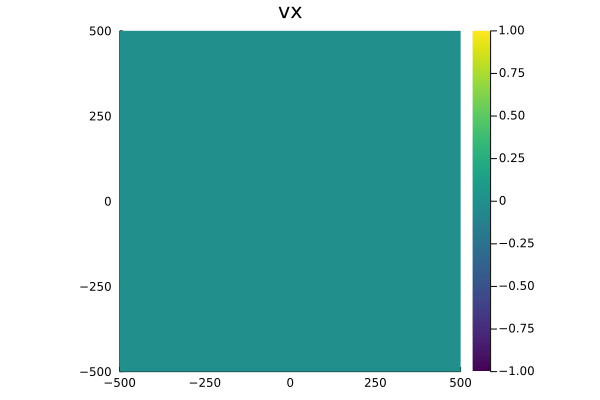

In [ ]:
ENV["GKSwstype"] = "nul"; if (isdir("viz3D_out") == false) mkdir("viz3D_out") else foreach(rm, filter(endswith(".png"), readdir("./viz3D_out",join=true))) end; loadpath = "./viz3D_out/"; anim = Animation(loadpath, String[])

	println("Animation directory: $(anim.dir)")
	# Time loop
	@showprogress for it=1:nt
	    if (it == 11)  global wtime0 = Base.time()  end
	   

	    @parallel compute_dv!(vx, vy, vz,dvx_dx,dvy_dy,dvz_dz,dvx_dy,dvx_dz,dvy_dx,dvy_dz,dvz_dx,dvz_dy,reverse(step.(mgrid))...)
	    @parallel (1:size(dvx_dx,1),1:size(dvx_dx,2),1:size(dvx_dx,3)) memoryx!(memory_dvx_dx,dvx_dx,pmlx[:a],pmlx[:b],pmlx[:kI])
	    @parallel (1:size(dvy_dy,1),1:size(dvy_dy,2),1:size(dvy_dy,3)) memoryx!(memory_dvy_dy,dvy_dy,pmlx[:a],pmlx[:b],pmlx[:kI])
	    @parallel (1:size(dvz_dz,1),1:size(dvz_dz,2),1:size(dvz_dz,3)) memoryx!(memory_dvz_dz,dvz_dz,pmlx[:a],pmlx[:b],pmlx[:kI])

	    @parallel (1:size(dvx_dy,1),1:size(dvx_dy,2),1:size(dvx_dy,3)) memoryy!(memory_dvx_dy,dvx_dy,pmly[:a_half],pmly[:b_half],pmly[:k_halfI])
	    @parallel (1:size(dvx_dz,1),1:size(dvx_dz,2),1:size(dvx_dz,3)) memoryy!(memory_dvx_dz,dvx_dz,pmly[:a_half],pmly[:b_half],pmly[:k_halfI])
	    @parallel (1:size(dvy_dx,1),1:size(dvy_dx,2),1:size(dvy_dx,3)) memoryy!(memory_dvy_dx,dvy_dx,pmly[:a_half],pmly[:b_half],pmly[:k_halfI])

	    @parallel (1:size(dvy_dz,1),1:size(dvy_dz,2),1:size(dvy_dz,3)) memoryx!(memory_dvy_dz,dvy_dz,pmlz[:a_half],pmlz[:b_half],pmlz[:k_halfI])
	    @parallel (1:size(dvz_dx,1),1:size(dvz_dx,2),1:size(dvz_dx,3)) memoryx!(memory_dvz_dx,dvz_dx,pmlz[:a_half],pmlz[:b_half],pmlz[:k_halfI])
	    @parallel (1:size(dvz_dy,1),1:size(dvz_dy,2),1:size(dvz_dy,3)) memoryx!(memory_dvz_dy,dvz_dy,pmlz[:a_half],pmlz[:b_half],pmlz[:k_halfI])

	    @parallel compute_tauii!(tauxx, tauyy, tauzz, dvx_dx, dvy_dy, dvz_dz, step(tgrid), lambda2mu, lambda)
	    tauxx[div(nx, 2),div(ny, 2),div(nz, 2)] += wav[it]*1e7
	    @parallel compute_tauij!(tauxy, tauxz, tauyz, dvx_dy,dvx_dz,dvy_dx,dvy_dz,dvz_dx,dvz_dy, step(tgrid), mu)
	    @parallel compute_dtau!(tauxx, tauyy, tauzz, tauxy, tauxz, tauyz, dtauxx_dx, dtauxy_dx, dtauxz_dx, dtauyy_dy, dtauxy_dy, dtauyz_dy, dtauzz_dz, dtauyz_dz, dtauxz_dz, reverse(step.(mgrid))...)

	    @parallel (1:size(dtauxx_dx,1),1:size(dtauxx_dx,2),1:size(dtauxx_dx,3)) memoryx!(memory_dtauxx_dx, dtauxx_dx, pmlx[:a_half], pmlx[:b_half], pmlx[:k_halfI])
	    @parallel (1:size(dtauxy_dx,1),1:size(dtauxy_dx,2),1:size(dtauxy_dx,3)) memory1x!(memory_dtauxy_dx, dtauxy_dx, pmlx[:a], pmlx[:b], pmlx[:kI])
	    @parallel (1:size(dtauxz_dx,1),1:size(dtauxz_dx,2),1:size(dtauxz_dx,3)) memory1x!(memory_dtauxz_dx, dtauxz_dx, pmlx[:a], pmlx[:b], pmlx[:kI])

	    @parallel (1:size(dtauyy_dy,1),1:size(dtauyy_dy,2),1:size(dtauyy_dy,3)) memoryy!(memory_dtauyy_dy, dtauyy_dy, pmly[:a_half], pmly[:b_half], pmly[:k_halfI])
	    @parallel (1:size(dtauxy_dy,1),1:size(dtauxy_dy,2),1:size(dtauxy_dy,3)) memory1y!(memory_dtauxy_dy, dtauxy_dy, pmly[:a], pmly[:b], pmly[:kI])
	    @parallel (1:size(dtauyz_dy,1),1:size(dtauyz_dy,2),1:size(dtauyz_dy,3)) memory1y!(memory_dtauyz_dy, dtauyz_dy, pmly[:a], pmly[:b], pmly[:kI])

	    @parallel (1:size(dtauzz_dz,1),1:size(dtauzz_dz,2),1:size(dtauzz_dz,3)) memoryz!(memory_dtauzz_dz, dtauzz_dz, pmlz[:a_half], pmlz[:b_half], pmlz[:k_halfI])
	    @parallel (1:size(dtauyz_dz,1),1:size(dtauyz_dz,2),1:size(dtauyz_dz,3)) memory1z!(memory_dtauyz_dz, dtauyz_dz, pmlz[:a], pmlz[:b], pmlz[:kI])
	    @parallel (1:size(dtauxz_dz,1),1:size(dtauxz_dz,2),1:size(dtauxz_dz,3)) memory1z!(memory_dtauxz_dz, dtauxz_dz, pmlz[:a], pmlz[:b], pmlz[:kI])

	    @parallel compute_V!(vx, vy, vz, dtauxx_dx, dtauxy_dx, dtauxz_dx, dtauyy_dy, dtauxy_dy, dtauyz_dy, dtauzz_dz, dtauyz_dz, dtauxz_dz, step(tgrid), rho)

	    @parallel (1:ny,1:nz) dirichletx!(vx,vy,vz,nx)
	    @parallel (1:nx,1:nz) dirichlety!(vx,vy,vz,ny)
	    @parallel (1:nx,1:ny) dirichletz!(vx,vy,vz,nz)
	    # t = t + step(tgrid)
	    # Visualisation
	    if mod(it, nout) == 0
		heatmap(mgrid[3], mgrid[1], Array(vx)[1:end - 1,div(ny,2),:]', 
		aspect_ratio=1, xlims=(mgrid[3][1], mgrid[3][end]), ylims=(mgrid[1][1], mgrid[1][end]), c=:viridis, 
		title="vx",
		clims=(-1,1)
		); frame(anim)
	    end
	end
	# Performance
	wtime    = Base.time() - wtime0
	A_eff    = (4 * 2) / 1e9 * nx * ny * nz * sizeof(Data.Number)  # Effective main memory access per iteration [GB] (Lower bound of required memory access: H and dHdτ have to be read and written (dHdτ for damping): 4 whole-array memaccess; B has to be read: 1 whole-array memaccess)
	wtime_it = wtime / (nt - 10)                           # Execution time per iteration [s]
	T_eff    = A_eff / wtime_it                          # Effective memory throughput [GB/s]
	@printf("Total steps=%d, time=%1.3e sec (@ T_eff = %1.2f GB/s) \n", nt, wtime, round(T_eff, sigdigits=2))
	gif(anim, "acoustic3D.gif", fps=15)
	# return
    # end
    
    
    # acoustic3D()
    



In [1]:
# @parallel (1:ny,1:nz) dirichletx!(vx,vy,vz,nx)
Array(vx)[:,2,:]

LoadError: UndefVarError: vx not defined